In [145]:
import pandas as pd
import numpy as np

In [146]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [147]:
data=pd.read_csv('/content/drive/MyDrive/data/Twitter Analysis.csv')
data.head()

,Unnamed: 0,majority_target,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
0,0,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,0,5,0,1,0,33,3,5,19
1,1,True,End of eviction moratorium means millions of A...,1.0,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1621.0,31436.0,37184.0,64.0,...,0,2,1,0,0,0,14,0,2,34
2,2,True,End of eviction moratorium means millions of A...,1.0,THE SUPREME COURT is siding with super rich pr...,9.0,84.0,219.0,1184.0,0.0,...,0,1,0,0,0,0,3,0,4,10
3,3,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders\n\nBroken campaign promi...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,1,3,0,0,1,6,8,1,30
4,4,True,End of eviction moratorium means millions of A...,1.0,@OhComfy I agree. The confluence of events rig...,70.0,166.0,15282.0,2194.0,0.0,...,0,1,3,0,1,0,11,3,2,19


In [148]:
# Separate features and target
x = data.drop(columns=['BotScoreBinary'])
y = data['BotScoreBinary']

In [149]:
# Text data (tweet) preprocessing
max_words = 1000  # Max number of words in tokenizer
max_sequence_length = 100  # Max length of each sequence (tweets)


In [150]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x['tweet'])
sequences = tokenizer.texts_to_sequences(x['tweet'])
x_text = pad_sequences(sequences, maxlen=max_sequence_length)

In [151]:
# Numeric features scaling
numeric_features = [
    'followers_count', 'friends_count', 'statuses_count', 'listed_count',
    'retweets', 'mentions', 'Word count', 'adjectives', 'adverbs',
    'pronouns', 'capitals', 'digits', 'hashtags', 'URLs', 'ORG_percentage',
    'PERSON_percentage', 'cred', 'normalize_influence'
]

In [152]:
x_numeric = data[numeric_features].values
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x_numeric)

In [153]:
# Split data into training and testing sets
x_train_text, x_test_text, x_train_numeric, x_test_numeric, y_train, y_test = train_test_split(
    x_text, x_numeric_scaled, y, test_size=0.2, random_state=42)

In [154]:
# Address class imbalance
smote = SMOTE(random_state=42)
x_train_text_resampled, y_train_resampled = smote.fit_resample(x_train_text, y_train)
x_train_numeric_resampled, y_train_resampled = smote.fit_resample(x_train_numeric, y_train)

In [155]:
# Define RNN model architecture
embedding_dim = 50  # Dimension of word embeddings

In [156]:
# Text input branch
text_input = Input(shape=(max_sequence_length,), name='text_input')
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input)
lstm_layer = LSTM(30, kernel_regularizer=l2(0.01))(embedding_layer)
dropout_text = Dropout(0.5)(lstm_layer)

In [157]:
# Numeric input branch
numeric_input = Input(shape=(len(numeric_features),), name='numeric_input')
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(numeric_input)
dropout_numeric = Dropout(0.5)(dense_layer)

In [158]:
# Concatenate both branches
concatenated = concatenate([dropout_text, dropout_numeric])

In [159]:
# Output layer
output = Dense(1, activation='sigmoid', name='output')(concatenated)

In [160]:
# Create model
model = Model(inputs=[text_input, numeric_input], outputs=output)

In [161]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 100, 50)              50000     ['text_input[0][0]']          
                                                                                                  
 numeric_input (InputLayer)  [(None, 18)]                 0         []                            
                                                                                                  
 lstm_5 (LSTM)               (None, 30)                   9720      ['embedding_5[0][0]']         
                                                                                            

In [162]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [175]:
# Train model
history = model.fit(
    {'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled},
    y_train_resampled,
    epochs=20,
    batch_size=64,
    validation_data=({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
3245/3245 [==============================] - 213s 66ms/step - loss: 0.1577 - accuracy: 0.9457 - val_loss: 0.1506 - val_accuracy: 0.9484
Epoch 2/20
3245/3245 [==============================] - 218s 67ms/step - loss: 0.1553 - accuracy: 0.9467 - val_loss: 0.2033 - val_accuracy: 0.9249
Epoch 3/20
3245/3245 [==============================] - 221s 68ms/step - loss: 0.1479 - accuracy: 0.9494 - val_loss: 0.1504 - val_accuracy: 0.9462
Epoch 4/20
3245/3245 [==============================] - 223s 69ms/step - loss: 0.1381 - accuracy: 0.9539 - val_loss: 0.1407 - val_accuracy: 0.9547
Epoch 5/20
3245/3245 [==============================] - 220s 68ms/step - loss: 0.1262 - accuracy: 0.9590 - val_loss: 0.1266 - val_accuracy: 0.9595
Epoch 6/20
3245/3245 [==============================] - 217s 67ms/step - loss: 0.1170 - accuracy: 0.9625 - val_loss: 0.1185 - val_accuracy: 0.9623
Epoch 7/20
3245/3245 [==============================] - 210s 65ms/step - loss: 0.1117 - accuracy: 0.9637 - val_loss: 0

In [176]:
# Evaluate model on train set
train_loss, train_accuracy = model.evaluate({'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled}, y_train_resampled)
print(f'Train accuracy: {train_accuracy}')


6489/6489 [==============================] - 105s 16ms/step - loss: 0.0928 - accuracy: 0.9717
Train accuracy: 0.9716982841491699


In [177]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test)
print(f'Test accuracy: {test_accuracy}')

839/839 [==============================] - 13s 15ms/step - loss: 0.1073 - accuracy: 0.9670
Test accuracy: 0.9669895768165588


In [178]:
import matplotlib.pyplot as plt


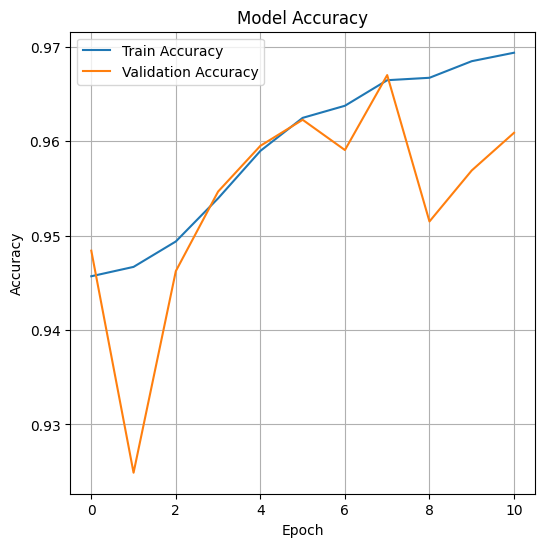

In [180]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [168]:
# Predict on test set
y_pred = model.predict({'text_input': x_test_text, 'numeric_input': x_test_numeric})
y_pred_classes = (y_pred > 0.5).astype(int)

839/839 [==============================] - 14s 16ms/step


In [169]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[24628  1418]
 [  243   551]]


In [170]:
import seaborn as sns

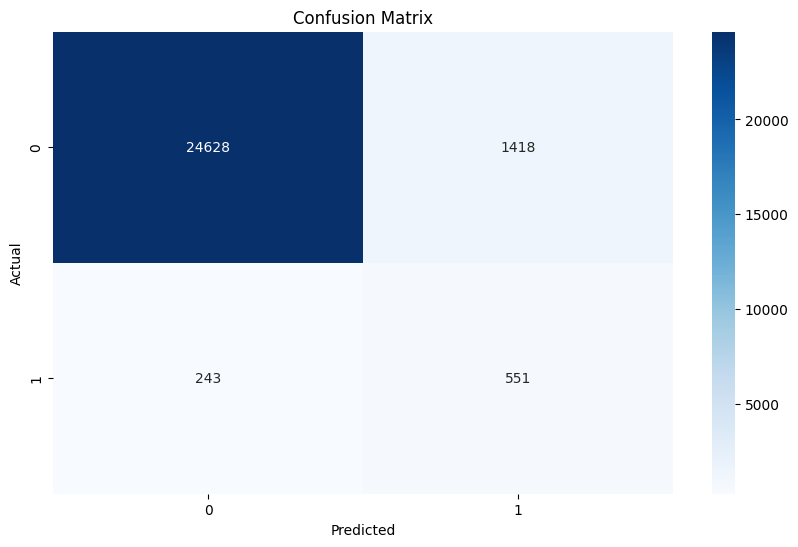

In [171]:
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [184]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     26046
         1.0       0.28      0.69      0.40       794

    accuracy                           0.94     26840
   macro avg       0.64      0.82      0.68     26840
weighted avg       0.97      0.94      0.95     26840



In [185]:
# Save the model to a TensorFlow SavedModel format
model.save('project_verity_function_2(V3).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
